# Case - Modelo preditivo para aprovação de crédito

@author: Matheus Alexandre

## Importações

In [1]:
import time
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import StandardScaler

from sklearn.compose import ColumnTransformer

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import cross_validate, GridSearchCV, cross_val_score, train_test_split

- Leitura dos datasets de treinamento

In [2]:
df_train = pd.read_csv('treino.csv')

In [3]:
df_train.head()

,inadimplente,util_linhas_inseguras,idade,vezes_passou_de_30_59_dias,razao_debito,salario_mensal,numero_linhas_crdto_aberto,numero_vezes_passou_90_dias,numero_emprestimos_imobiliarios,numero_de_vezes_que_passou_60_89_dias,numero_de_dependentes
0,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
1,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
2,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
3,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
4,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0


In [4]:
print("DataFrame Treinamento -  linhas:", df_train.shape[0]," colunas:", df_train.shape[1])

DataFrame Treinamento -  linhas: 110000  colunas: 11


## Entendimento da base de dados

- Durante a exploração dos dados, é possível identificar possíveis anomalias presente e até mesmo gerar alguns *insights* iniciais de como lidar com os dados.

In [5]:
df_train.describe()

,inadimplente,util_linhas_inseguras,idade,vezes_passou_de_30_59_dias,razao_debito,salario_mensal,numero_linhas_crdto_aberto,numero_vezes_passou_90_dias,numero_emprestimos_imobiliarios,numero_de_vezes_que_passou_60_89_dias,numero_de_dependentes
count,110000.000000,110000.000000,110000.000000,110000.000000,110000.000000,8.823700e+04,110000.000000,110000.000000,110000.000000,110000.000000,107122.000000
mean,0.066645,5.929979,52.255636,0.424055,354.823589,6.637411e+03,8.445573,0.269955,1.019891,0.243891,0.757482
std,0.249408,252.301965,14.768241,4.240780,2074.140421,1.338395e+04,5.139026,4.217326,1.135989,4.204137,1.114670
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.030054,41.000000,0.000000,0.175016,3.400000e+03,5.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.155936,52.000000,0.000000,0.366682,5.400000e+03,8.000000,0.000000,1.000000,0.000000,0.000000
75%,0.000000,0.562806,63.000000,0.000000,0.866874,8.225000e+03,11.000000,0.000000,2.000000,0.000000,1.000000
max,1.000000,50708.000000,109.000000,98.000000,329664.000000,3.008750e+06,58.000000,98.000000,54.000000,98.000000,20.000000


- Existe um registro com `idade` igual a 0. Uma possibilidade para isso ter ocorrido são valores não preenchido (NaN) convertidos para numérico.
- O valor mínimo para salário é 0, o que indica que não necessariamente os clientes devem possuir salário para terem crédito aprovado.

In [6]:
print('Registros com idade abaixo de 18:', df_train.loc[ df_train.idade < 18, 'idade'].count())

Registros com idade abaixo de 18: 1


- O preenchimento de valores ausentes é um importante estágio, impactando diretamente no resultado de predição do modelo.
- Por se tratar de apenas um registro com valor 0, o método a ser utilizado para a correção será o descarte (drop).

In [7]:
df_train.drop(df_train[ df_train.idade == 0 ].index, inplace=True)

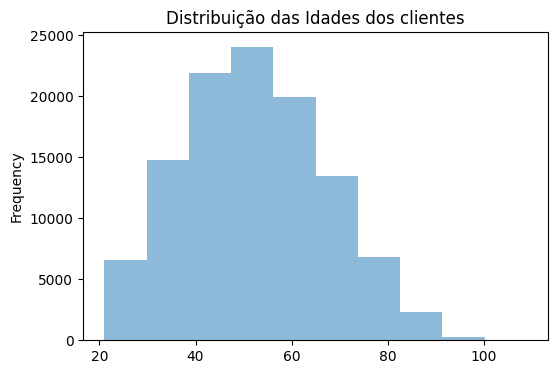

In [8]:
df_train.idade.plot(
    kind='hist',
    title='Distribuição das Idades dos clientes',
    xlabel='Idade',
    ylabel='Frequêcia',
    **{
        'alpha': 0.5,
        'figsize': (6,4)
      }
);

In [9]:
df_train.isna().sum()

inadimplente                                 0
util_linhas_inseguras                        0
idade                                        0
vezes_passou_de_30_59_dias                   0
razao_debito                                 0
salario_mensal                           21763
numero_linhas_crdto_aberto                   0
numero_vezes_passou_90_dias                  0
numero_emprestimos_imobiliarios              0
numero_de_vezes_que_passou_60_89_dias        0
numero_de_dependentes                     2878
dtype: int64

- As variáveis `salario_mensal` e `numero_de_dependentes` são as únicas com valores NaN. A ausência desses valores é perfeitamente plausível.
- Existem várias abordagens para lidar com valores ausentes: imputar valores com a média, moda, mediana, regressão linear, constante, etc. A abordagem a ser utilizada neste caso será a constante com valor 0.

In [10]:
df_train.fillna(value=0, inplace=True)

## Remoção de duplicatas

In [11]:
df_train.drop_duplicates(inplace=True)

## Escalonamento das variáveis

- Alguns algoritmos de aprendizado de máquina se beneficiam de padronizações ou normalizações dos dados. Aqueles que fazem uso do cálculo de alguma distância (seja euclidiana ou não), atuam melhor com dados padronizados.

In [12]:
df_train_scaled = df_train.copy()

In [13]:
X = df_train.drop('inadimplente', axis=1)

scaler = StandardScaler()
scaler.fit(X)

df_train_scaled[X.columns] = scaler.transform(df_train[X.columns])

### Distribuição das classes

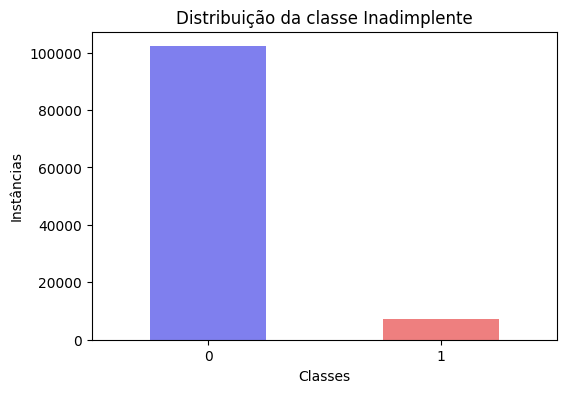

In [14]:
df_train_scaled.inadimplente.value_counts().plot(
    kind='bar',
    title='Distribuição da classe Inadimplente',
    xlabel='Classes',
    ylabel='Instâncias',
    color=["#0101DF", "#DF0101"],
    rot=0,
    **{
        'alpha': 0.5,
        'figsize': (6,4)
      }
);

In [15]:
cls_samples = df_train_scaled.inadimplente.value_counts()[0]
print(f'Adimplentes: {round(cls_samples/len(df_train_scaled) * 100,2)}% do dataset com {cls_samples} amostras.')

Adimplentes: 93.32% do dataset com 102178 amostras.


In [16]:
cls_samples = df_train_scaled.inadimplente.value_counts()[1]
print(f'Inadimplentes: {round(cls_samples/len(df_train_scaled) * 100,2)}% do dataset com {cls_samples} amostas.')

Inadimplentes: 6.68% do dataset com 7313 amostas.


- Outro problema bastante comum é o desbalanceamento de classes. No dataset fornecido, 6.68% dos dados pertencem à classe 1 (inadimplente).
- Isso implica, além de outros fatores, na decisão de qual métrica utilizar para avaliar o modelo. A acurácia não é aconselhada pois, ao prever tudo como sendo da classe 0, pode fornecer uma falsa impressão de corretude do modelo, proporcionando um resultado de aproximadamente 93%. Como existe uma necessidade de identificar os casos em que os clientes são inadimplentes, outras métricas serão levadas em consideração.
- Para contornar essa questão, é necessário fazer o balanceamento das classes. O métodos escolhido é o RandomOverSampler, que de acordo com a própria documentação:
> "... sobreamostra a(s) classe(s) minoritária(s) escolhendo amostras aleatoriamente com reposição."

In [17]:
X = df_train_scaled.drop('inadimplente', axis=1)
y = df_train_scaled.inadimplente

X_Over, Y_Over = RandomOverSampler(random_state=42).fit_resample(X, y)

In [18]:
print(f'Distribuição das classes:\n{Y_Over.value_counts()}')

Distribuição das classes:
1    102178
0    102178
Name: inadimplente, dtype: int64


## Treinamento e Seleção dos Algoritmos

- A biblioteca scikit-learn proporciona dezenas de algoritmos de aprendizado de máquina. Com o intuito de ser mais sucinto, foram escolhidos apenas alguns que possuem diferentes abordagens. Dentre eles: Regressão Logística, KNN, Support Vector Machine, Random Forest e Gradient Boosting.
- O que possuir a melhor combinação de parâmetros será posteriormente refinado e definido como modelo final para a tarefa.

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X_Over, Y_Over, test_size=0.20, random_state=42)

In [20]:
classifiers = {
    "LogisiticRegression": LogisticRegression(),
    "KNearest": KNeighborsClassifier(),
    "SupportVectorClassifier": SVC(),
    "RandomForestClassifier": RandomForestClassifier(),
    "GradientBoostingClassifier": GradientBoostingClassifier()
}

In [21]:
for name, clf in classifiers.items():
    start = time.time()
    clf.fit(X_train, y_train)
    stop = time.time()
    
    y_pred = clf.predict(X_test)
    
    print(f'Classificador: {name} | em {stop - start:.2f}s')
    print(f'Recall Score: {recall_score(y_test, y_pred):.4f}')
    print(f'Precision Score: {precision_score(y_test, y_pred):.4f}')
    print(f'F1 Score: {f1_score(y_test, y_pred):.4f}')
    print(f'Accuracy Score: {accuracy_score(y_test, y_pred):.4f}')
    print(f'AUC Score: {roc_auc_score(y_test, y_pred):.4f}')
    print(50*'-')

Classificador: LogisiticRegression | em 0.19s
Recall Score: 0.6478
Precision Score: 0.7722
F1 Score: 0.7046
Accuracy Score: 0.7282
AUC Score: 0.7282
--------------------------------------------------
Classificador: KNearest | em 0.26s
Recall Score: 0.9997
Precision Score: 0.8757
F1 Score: 0.9336
Accuracy Score: 0.9288
AUC Score: 0.9288
--------------------------------------------------
Classificador: SupportVectorClassifier | em 487.32s
Recall Score: 0.6756
Precision Score: 0.8181
F1 Score: 0.7401
Accuracy Score: 0.7625
AUC Score: 0.7626
--------------------------------------------------
Classificador: RandomForestClassifier | em 18.10s
Recall Score: 1.0000
Precision Score: 0.9715
F1 Score: 0.9855
Accuracy Score: 0.9853
AUC Score: 0.9853
--------------------------------------------------
Classificador: GradientBoostingClassifier | em 14.66s
Recall Score: 0.7983
Precision Score: 0.7907
F1 Score: 0.7945
Accuracy Score: 0.7933
AUC Score: 0.7933
--------------------------------------------

- Dos resultados obtidos, os algoritmos KNN e RandomForest se saíram melhores. Inclusive, o segundo retornou 100% na métrica recall, o que indica a ausência de falsos positivos.
- A etapa seguinte é a de ajustes dos parâmetros, com o intuito de melhorar ainda mais os resultados do RandomForest.

## Refinamento dos Parâmetros

In [22]:
rf_params = {
    # Número de árvores no random forest
    'n_estimators': range(100, 200, 20),
    # Número de atributos a ser considerado a cada divisão
    'max_features': ['auto', 'sqrt'],
    # Número máximo de profundidade na árvore
    'max_depth': [None, 2, 4],
    # Número mínimo de amostrar para cada divisão
    'min_samples_split': [2, 5],
    # Número mínimo de amostras necessárias para estar em um nó folha
    'min_samples_leaf': [1, 2],
    # Se as amostras bootstrap são usadas ao construir árvores.
    'bootstrap': [True, False]
}

In [23]:
clf = RandomForestClassifier(
    ccp_alpha=0.0,
    class_weight=None,
    criterion='gini',
    max_leaf_nodes=None,
    max_samples=None,
    min_impurity_decrease=0.0,
    min_weight_fraction_leaf=0.0,
    n_jobs=None,
    oob_score=False,
    random_state=None,
    verbose=0,
    warm_start=False
)

rscv = GridSearchCV(
    clf, 
    rf_params, 
    cv=3,
    scoring='roc_auc', 
    return_train_score=False, 
    verbose=3, 
    n_jobs=-1
)

In [24]:
start = time.time()
random_search = rscv.fit(X_train, y_train)
stop = time.time()
print(f'Tempo de execução: {stop-start:.2f}s')
print(f'Melhor valor de AUC: {random_search.best_score_:.4f}')

Fitting 3 folds for each of 240 candidates, totalling 720 fits
Tempo de execução: 1038.25s
Melhor valor de AUC: 0.9996


In [25]:
# Visualização dos parâmetros do melhor caso
random_search.best_params_

{'bootstrap': False,
 'max_depth': None,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 180}

## Matriz de confusão

- Para finalizar os testes no algoritmo de aprendizado, a matriz de confusão mostra como foram realizadas as predição para cada classe.
- Assim podemos ter ideia de como, de fato, o modelo está se comportando diante dos dados fornecidos.

In [26]:
clf = RandomForestClassifier(**random_search.best_params_)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

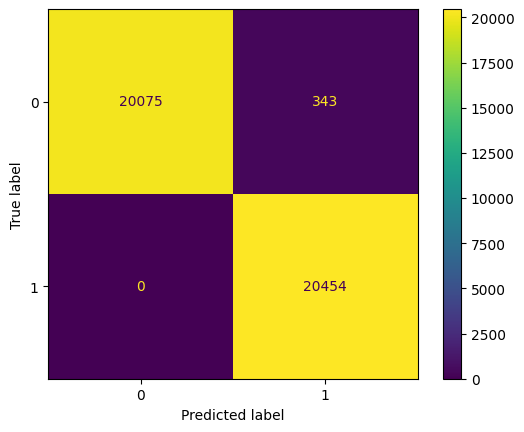

In [27]:
cm = confusion_matrix(y_test, y_pred)

cm_display = ConfusionMatrixDisplay(cm).plot(values_format='')

## Teste no dataset final

In [28]:
df_test = pd.read_csv('teste.csv')

In [29]:
df_test.head()

,util_linhas_inseguras,idade,vezes_passou_de_30_59_dias,razao_debito,salario_mensal,numero_linhas_crdto_aberto,numero_vezes_passou_90_dias,numero_emprestimos_imobiliarios,numero_de_vezes_que_passou_60_89_dias,numero_de_dependentes
0,0.025849,62,0,0.081775,8180.0,3,0,2,0,0.0
1,0.667083,55,0,0.153112,2200.0,3,0,0,0,0.0
2,0.007093,44,0,0.148800,7499.0,20,0,1,0,0.0
3,0.091213,54,0,0.351635,5900.0,15,0,1,1,0.0
4,0.112680,54,0,0.065959,2167.0,3,0,0,0,0.0


In [30]:
df_test_scaled = df_test.copy()
df_test_scaled[df_test_scaled.columns] = scaler.transform(df_test[df_test.columns])

In [31]:
df_test_scaled.isna().sum()

util_linhas_inseguras                       0
idade                                       0
vezes_passou_de_30_59_dias                  0
razao_debito                                0
salario_mensal                           7968
numero_linhas_crdto_aberto                  0
numero_vezes_passou_90_dias                 0
numero_emprestimos_imobiliarios             0
numero_de_vezes_que_passou_60_89_dias       0
numero_de_dependentes                    1046
dtype: int64

In [32]:
df_test_scaled.fillna(value=0, inplace=True)

In [33]:
df_test_scaled['inadimplente'] = clf.predict(df_test_scaled)

In [39]:
features = df_test_scaled.drop('inadimplente', axis=1).columns

In [40]:
df_test_scaled[features] = scaler.inverse_transform(df_test_scaled[features])

In [41]:
df_test_scaled.head()

,util_linhas_inseguras,idade,vezes_passou_de_30_59_dias,razao_debito,salario_mensal,numero_linhas_crdto_aberto,numero_vezes_passou_90_dias,numero_emprestimos_imobiliarios,numero_de_vezes_que_passou_60_89_dias,numero_de_dependentes,inadimplente
0,0.025849,62.0,0.0,0.081775,8180.0,3.0,0.0,2.0,0.0,0.0,0
1,0.667083,55.0,0.0,0.153112,2200.0,3.0,0.0,0.0,0.0,0.0,0
2,0.007093,44.0,0.0,0.148800,7499.0,20.0,0.0,1.0,0.0,0.0,0
3,0.091213,54.0,0.0,0.351635,5900.0,15.0,0.0,1.0,1.0,0.0,0
4,0.112680,54.0,0.0,0.065959,2167.0,3.0,0.0,0.0,0.0,0.0,0


In [42]:
df_test_scaled.to_csv("./prediction/teste.csv", index=0)